In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import os
import torch
from tqdm import tqdm

pd.set_option('display.max_colwidth', None)

# 1,000 단위 표기
pd.options.display.float_format = '{:,.5f}'.format

# Unicode warning 제거 (폰트 관련 경고메시지)
plt.rcParams['axes.unicode_minus']=False

# 그래프 출력 사이즈 설정
plt.rcParams["figure.figsize"] = (10, 6)

# 경고 무시
warnings.filterwarnings('ignore')

# Data 경로 설정
DATA_DIR = 'data'

# 시드설정
SEED = 123

def seed_everything(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(SEED)

%matplotlib inline

/var/folders/_0/7lvqf88d2hxdjf1k1f_0gbs00000gn/T/ipykernel_31164/2210612969.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [5]:
# FinanceDataReader 설치
!pip install finance-datareader -q
!pip install plotly -q

In [12]:
import FinanceDataReader as fdr

# 삼성전자 주가 데이터 로드
df = fdr.DataReader("005930")
df = df.drop("Change", axis=1)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
1999-11-05,4440,4490,4320,4320,609784
1999-11-08,4340,4350,4190,4200,612169
1999-11-09,4220,4460,4170,4430,947061
1999-11-10,4400,4420,4300,4320,707761
1999-11-11,4390,4480,4320,4330,747622


In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)
scaled[:5]

array([[0.04916944, 0.0463843 , 0.04826816, 0.01801291, 0.00675241],
       [0.04806202, 0.04493802, 0.04681564, 0.01665345, 0.00677882],
       [0.04673311, 0.04607438, 0.04659218, 0.01925909, 0.01048722],
       [0.04872647, 0.04566116, 0.04804469, 0.01801291, 0.00783735],
       [0.04861573, 0.04628099, 0.04826816, 0.0181262 , 0.00827875]])

In [17]:
scaled_df = pd.DataFrame(scaled, index=df.index, columns=df.columns)
scaled_df

,Open,High,Low,Close,Volume
Date,,,,,
1999-11-05,0.04917,0.04638,0.04827,0.01801,0.00675
1999-11-08,0.04806,0.04494,0.04682,0.01665,0.00678
1999-11-09,0.04673,0.04607,0.04659,0.01926,0.01049
1999-11-10,0.04873,0.04566,0.04804,0.01801,0.00784
1999-11-11,0.04862,0.04628,0.04827,0.01813,0.00828
...,...,...,...,...,...
2024-02-21,0.81285,0.76136,0.81453,0.79608,0.12738
2024-02-22,0.81728,0.76343,0.81229,0.79721,0.16842
2024-02-23,0.81506,0.76653,0.81453,0.79495,0.17967


## Windowed Dataset


In [18]:
N_PREDICTIONS = 1
N_FEATURES = 4
WINDOW_SIZE = 10

In [19]:
def make_dataset(series, target, window_size=WINDOW_SIZE, n_predictions=N_PREDICTIONS):
    Xs = []
    Ys = []
    for i in range(len(series) - window_size - n_predictions + 1):
        Xs.append(series.iloc[i : i + window_size].drop(target, axis=1))
        Ys.append(
            series.iloc[i + window_size : i + window_size + n_predictions].loc[
                :, target
            ]
        )
    return np.array(Xs), np.array(Ys)

In [20]:
# 데이터셋 생성
Xs, Ys = make_dataset(scaled_df, "Close")
Xs.shape, Ys.shape

((5990, 10, 4), (5990, 1))

In [21]:
n_splits = 200

x_train, y_train = Xs[:-n_splits], Ys[:-n_splits]
x_valid, y_valid = Xs[-n_splits:], Ys[-n_splits:]

In [22]:
x_train.shape, y_train.shape

((5790, 10, 4), (5790, 1))

In [23]:
x_valid.shape, y_valid.shape

((200, 10, 4), (200, 1))

In [24]:
scaled_df[-10:]

,Open,High,Low,Close,Volume
Date,,,,,
2024-02-14,0.81617,0.76756,0.82346,0.80741,0.13770
2024-02-15,0.82171,0.76860,0.81564,0.79608,0.15636
2024-02-16,0.81174,0.75826,0.81006,0.79381,0.14888
2024-02-19,0.80620,0.76343,0.81341,0.80514,0.14093
2024-02-20,0.81617,0.76136,0.81341,0.79948,0.16257
2024-02-21,0.81285,0.76136,0.81453,0.79608,0.12738
2024-02-22,0.81728,0.76343,0.81229,0.79721,0.16842
2024-02-23,0.81506,0.76653,0.81453,0.79495,0.17967
2024-02-26,0.80066,0.75620,0.80670,0.79381,0.16244


In [25]:
x_valid[-1]

array([[0.82834994, 0.7768595 , 0.83128492, 0.24324742],
       [0.81616833, 0.76756198, 0.82346369, 0.13769761],
       [0.82170543, 0.76859504, 0.81564246, 0.15636361],
       [0.81173865, 0.75826446, 0.81005587, 0.14887997],
       [0.80620155, 0.76342975, 0.81340782, 0.14092507],
       [0.81616833, 0.76136364, 0.81340782, 0.16257445],
       [0.81284607, 0.76136364, 0.81452514, 0.12738326],
       [0.81727575, 0.76342975, 0.8122905 , 0.16841521],
       [0.81506091, 0.76652893, 0.81452514, 0.1796684 ],
       [0.80066445, 0.75619835, 0.80670391, 0.16244018]])

In [26]:
y_valid[-1]

array([0.79494732])

## Tensor DataSet 생성


In [27]:
def make_tensor(x, device):
    return torch.FloatTensor(x).to(device)

In [28]:
# CUDA 사용 가능 여부 확인
if torch.backends.mps.is_built():
    # mac os mps 지원 체크
    device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")
else:
    # cuda 사용 가능한지 체크
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

mps


In [29]:
x_train = make_tensor(x_train, device=device)
y_train = make_tensor(y_train, device=device)
x_valid = make_tensor(x_valid, device=device)
y_valid = make_tensor(y_valid, device=device)

In [30]:
train_ds = torch.utils.data.TensorDataset(x_train, y_train)
valid_ds = torch.utils.data.TensorDataset(x_valid, y_valid)

## DataLoader 생성


In [56]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(
    dataset=train_ds, batch_size=batch_size, shuffle=False
)

validation_loader = torch.utils.data.DataLoader(
    dataset=valid_ds, batch_size=batch_size, shuffle=False
)

In [57]:
x, y = next(iter(train_loader))
x, y = x.to(device), y.to(device)

In [58]:
x.shape

torch.Size([32, 10, 4])

## Conv1d

![](https://i.stack.imgur.com/NmYZJ.png)


In [38]:
import torch.nn as nn

conv1 = nn.Conv1d(
    in_channels=WINDOW_SIZE,
    out_channels=50,
    kernel_size=3,
    padding="same",
    device=device,
)
conv_out = conv1(x)
print(f"입력 shape: {x.shape}")
print(f"출력 shape: {conv_out.shape}")

입력 shape: torch.Size([32, 10, 4])
출력 shape: torch.Size([32, 50, 4])


## 모델


In [39]:
import torch
import torch.nn as nn
import torch.optim as optim

In [40]:
class BaseModel(nn.Module):
    def __init__(
        self,
        input_size,
        window_size,
        hidden_size,
        output_size,
        num_layers,
        bidirectional=True,
        drop_prob=0.1,
    ):
        super(BaseModel, self).__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = 2 if bidirectional else 1

        self.conv = nn.Conv1d(
            in_channels=window_size,
            out_channels=64,
            kernel_size=3,
            padding="same",
            device=device,
        )
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True,
        )

        self.dropout = nn.Dropout(drop_prob)

        self.fc = nn.Linear(hidden_size * self.bidirectional, output_size)

    def init_hidden_and_cell_state(self, batch_size, device):
        self.hidden_and_cell = (
            torch.zeros(
                self.num_layers * self.bidirectional, batch_size, self.hidden_size
            ).to(device),
            torch.zeros(
                self.num_layers * self.bidirectional, batch_size, self.hidden_size
            ).to(device),
        )

    def forward(self, x):
        x = self.conv(x)
        output, (h, c) = self.lstm(x, self.hidden_and_cell)
        h = output[:, -1, :]
        o = self.dropout(h)
        o = self.fc(o)
        return o

In [41]:
config = {
    "input_size": N_FEATURES,
    "window_size": WINDOW_SIZE,
    "hidden_size": 64,
    "num_layers": 2,
    "bidirectional": True,
    "output_size": N_PREDICTIONS,
}

model = BaseModel(**config)

In [42]:
x, y = next(iter(train_loader))
x.to(device), y.to(device)

model = model.to(device)
model.init_hidden_and_cell_state(batch_size, device)
output = model(x)

In [43]:
output.shape

torch.Size([32, 1])

## 손실함수 & 옵티마이저 정의


In [77]:
model = model.to(device)
loss_fn = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=5e-5)

## 모델 훈련


In [78]:
from tqdm import tqdm


def fit(model, data_loader, loss_fn, optimizer, device, phase="train"):
    if phase == "train":
        # 모델을 훈련모드로 설정합니다. training mode 일 때 Gradient 가 업데이트 됩니다. 반드시 train()으로 모드 변경을 해야 합니다.
        model.train()
    else:
        # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다.
        model.eval()

    # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
    running_loss = 0
    running_metric = 0

    # 예쁘게 Progress Bar를 출력하면서 훈련 상태를 모니터링 하기 위하여 tqdm으로 래핑합니다.
    prograss_bar = tqdm(
        data_loader, leave=False, unit="batch", total=len(data_loader), mininterval=1
    )

    # mini-batch 학습을 시작합니다.
    for x, y in prograss_bar:
        # image, label 데이터를 device에 올립니다.
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        # 누적 Gradient를 초기화 합니다.
        with torch.set_grad_enabled(phase == "train"):
            model.init_hidden_and_cell_state(len(x), device)
            # Forward Propagation을 진행하여 결과를 얻습니다.
            output = model(x)

            # 손실함수에 output, label 값을 대입하여 손실을 계산합니다.
            loss = loss_fn(output, y)

            if phase == "train":
                # 오차역전파(Back Propagation)을 진행하여 미분 값을 계산합니다.
                loss.backward()

                # 계산된 Gradient를 업데이트 합니다.
                optimizer.step()

        # 추가로 설정한 평가지표를 계산합니다.
        metric = nn.L1Loss()(output, y)
        running_metric += metric

        # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
        running_loss += loss.item()

    # 평균 손실(loss)과 정확도를 반환합니다.
    # train_loss, train_acc
    return running_loss / len(data_loader), running_metric / len(data_loader)

In [79]:
import time

# 최대 Epoch을 지정합니다.
num_epochs = 50

min_loss = np.inf

STATE_DICT_PATH = "TimeSeries-Prediction.pth"

# Epoch 별 훈련 및 검증을 수행합니다.
for epoch in range(num_epochs):
    # Model Training
    # 훈련 손실과 정확도를 반환 받습니다.
    start = time.time()
    train_loss, train_mae = fit(
        model, train_loader, loss_fn, optimizer, device, phase="train"
    )

    # 검증 손실과 검증 정확도를 반환 받습니다.
    val_loss, val_mae = fit(
        model, validation_loader, loss_fn, optimizer, device, phase="eval"
    )

    # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치(weights)를 저장합니다.
    if val_loss < min_loss:
        print(
            f"[INFO] val_loss has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!"
        )
        min_loss = val_loss
        torch.save(model.state_dict(), STATE_DICT_PATH)

    time_elapsed = time.time() - start
    # Epoch 별 결과를 출력합니다.
    print(
        f"[Epoch{epoch+1:02d}] time: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s \t loss: {train_loss:.5f}, mae: {train_mae:.5f} | val_loss: {val_loss:.5f}, val_mae: {val_mae:.5f}"
    )

[INFO] val_loss has been improved from inf to 0.01274. Saving Model!
[Epoch01] time: 0m 3s 	 loss: 0.01152, mae: 0.01152 | val_loss: 0.01274, val_mae: 0.01274


[INFO] val_loss has been improved from 0.01274 to 0.01264. Saving Model!
[Epoch02] time: 0m 3s 	 loss: 0.01121, mae: 0.01121 | val_loss: 0.01264, val_mae: 0.01264


[Epoch03] time: 0m 3s 	 loss: 0.01074, mae: 0.01074 | val_loss: 0.01313, val_mae: 0.01313


[Epoch04] time: 0m 3s 	 loss: 0.01046, mae: 0.01046 | val_loss: 0.01278, val_mae: 0.01278


[INFO] val_loss has been improved from 0.01264 to 0.01263. Saving Model!
[Epoch05] time: 0m 3s 	 loss: 0.01034, mae: 0.01034 | val_loss: 0.01263, val_mae: 0.01263


[Epoch06] time: 0m 3s 	 loss: 0.01042, mae: 0.01042 | val_loss: 0.01387, val_mae: 0.01387


[INFO] val_loss has been improved from 0.01263 to 0.01255. Saving Model!
[Epoch07] time: 0m 3s 	 loss: 0.01032, mae: 0.01032 | val_loss: 0.01255, val_mae: 0.01255


[Epoch08] time: 0m 3s 	 loss: 0.01033, mae: 0.01033 | val_loss: 0.01285, val_mae: 0.01285


[Epoch09] time: 0m 3s 	 loss: 0.01043, mae: 0.01043 | val_loss: 0.01260, val_mae: 0.01260


[Epoch10] time: 0m 3s 	 loss: 0.01004, mae: 0.01004 | val_loss: 0.01423, val_mae: 0.01423


[Epoch11] time: 0m 3s 	 loss: 0.01015, mae: 0.01015 | val_loss: 0.01305, val_mae: 0.01305


[Epoch12] time: 0m 3s 	 loss: 0.01006, mae: 0.01006 | val_loss: 0.01283, val_mae: 0.01283


[Epoch13] time: 0m 3s 	 loss: 0.01002, mae: 0.01002 | val_loss: 0.01358, val_mae: 0.01358


[Epoch14] time: 0m 3s 	 loss: 0.01011, mae: 0.01011 | val_loss: 0.01339, val_mae: 0.01339


[Epoch15] time: 0m 3s 	 loss: 0.01003, mae: 0.01003 | val_loss: 0.01328, val_mae: 0.01328


[Epoch16] time: 0m 3s 	 loss: 0.00990, mae: 0.00990 | val_loss: 0.01385, val_mae: 0.01385


[Epoch17] time: 0m 3s 	 loss: 0.01023, mae: 0.01023 | val_loss: 0.01313, val_mae: 0.01313


[Epoch18] time: 0m 3s 	 loss: 0.00996, mae: 0.00996 | val_loss: 0.01468, val_mae: 0.01468


[Epoch19] time: 0m 3s 	 loss: 0.01003, mae: 0.01003 | val_loss: 0.01452, val_mae: 0.01452


[Epoch20] time: 0m 3s 	 loss: 0.01009, mae: 0.01009 | val_loss: 0.01269, val_mae: 0.01269


[Epoch21] time: 0m 3s 	 loss: 0.01012, mae: 0.01012 | val_loss: 0.01281, val_mae: 0.01281


[Epoch22] time: 0m 3s 	 loss: 0.00971, mae: 0.00971 | val_loss: 0.01582, val_mae: 0.01582


[Epoch23] time: 0m 3s 	 loss: 0.00983, mae: 0.00983 | val_loss: 0.01312, val_mae: 0.01312


[Epoch24] time: 0m 3s 	 loss: 0.01006, mae: 0.01006 | val_loss: 0.01282, val_mae: 0.01282


[Epoch25] time: 0m 3s 	 loss: 0.00980, mae: 0.00980 | val_loss: 0.01439, val_mae: 0.01439


[Epoch26] time: 0m 3s 	 loss: 0.00985, mae: 0.00985 | val_loss: 0.01505, val_mae: 0.01505


[Epoch27] time: 0m 3s 	 loss: 0.00997, mae: 0.00997 | val_loss: 0.01365, val_mae: 0.01365


[Epoch28] time: 0m 3s 	 loss: 0.00997, mae: 0.00997 | val_loss: 0.01339, val_mae: 0.01339


[Epoch29] time: 0m 3s 	 loss: 0.00977, mae: 0.00977 | val_loss: 0.01439, val_mae: 0.01439


[Epoch30] time: 0m 3s 	 loss: 0.01000, mae: 0.01000 | val_loss: 0.01484, val_mae: 0.01484


[Epoch31] time: 0m 3s 	 loss: 0.00991, mae: 0.00991 | val_loss: 0.01511, val_mae: 0.01511


[INFO] val_loss has been improved from 0.01255 to 0.01246. Saving Model!
[Epoch32] time: 0m 3s 	 loss: 0.00997, mae: 0.00997 | val_loss: 0.01246, val_mae: 0.01246


[Epoch33] time: 0m 3s 	 loss: 0.00994, mae: 0.00994 | val_loss: 0.01463, val_mae: 0.01463


[Epoch34] time: 0m 3s 	 loss: 0.00984, mae: 0.00984 | val_loss: 0.01471, val_mae: 0.01471


[Epoch35] time: 0m 3s 	 loss: 0.00981, mae: 0.00981 | val_loss: 0.01397, val_mae: 0.01397


[Epoch36] time: 0m 3s 	 loss: 0.00968, mae: 0.00968 | val_loss: 0.01440, val_mae: 0.01440


[Epoch37] time: 0m 3s 	 loss: 0.00980, mae: 0.00980 | val_loss: 0.01461, val_mae: 0.01461


[Epoch38] time: 0m 3s 	 loss: 0.01034, mae: 0.01034 | val_loss: 0.01248, val_mae: 0.01248


[Epoch39] time: 0m 3s 	 loss: 0.00988, mae: 0.00988 | val_loss: 0.01458, val_mae: 0.01458


[Epoch40] time: 0m 3s 	 loss: 0.00980, mae: 0.00980 | val_loss: 0.01431, val_mae: 0.01431


[Epoch41] time: 0m 3s 	 loss: 0.00991, mae: 0.00991 | val_loss: 0.01383, val_mae: 0.01383


[Epoch42] time: 0m 3s 	 loss: 0.01013, mae: 0.01013 | val_loss: 0.01325, val_mae: 0.01325


[Epoch43] time: 0m 3s 	 loss: 0.00989, mae: 0.00989 | val_loss: 0.01281, val_mae: 0.01281


[Epoch44] time: 0m 3s 	 loss: 0.00989, mae: 0.00989 | val_loss: 0.01355, val_mae: 0.01355


[Epoch45] time: 0m 3s 	 loss: 0.00969, mae: 0.00969 | val_loss: 0.01269, val_mae: 0.01269


[Epoch46] time: 0m 3s 	 loss: 0.00977, mae: 0.00977 | val_loss: 0.01380, val_mae: 0.01380


[Epoch47] time: 0m 3s 	 loss: 0.00990, mae: 0.00990 | val_loss: 0.01347, val_mae: 0.01347


[Epoch48] time: 0m 3s 	 loss: 0.00973, mae: 0.00973 | val_loss: 0.01332, val_mae: 0.01332


[Epoch49] time: 0m 3s 	 loss: 0.00986, mae: 0.00986 | val_loss: 0.01605, val_mae: 0.01605


[Epoch50] time: 0m 3s 	 loss: 0.00961, mae: 0.00961 | val_loss: 0.01499, val_mae: 0.01499


## 저장한 가중치 로드


In [80]:
model.load_state_dict(torch.load(STATE_DICT_PATH))

<All keys matched successfully>

## Evaluation


In [81]:
model.eval()

results = []

with torch.no_grad():
    for x, y in validation_loader:
        x, y = x.to(device), y.to(device)
        model.init_hidden_and_cell_state(len(x), device)
        output = model(x)
        results.extend(output.detach().cpu().numpy().flatten().tolist())

len(results)

200

## 예측 결과 시각화


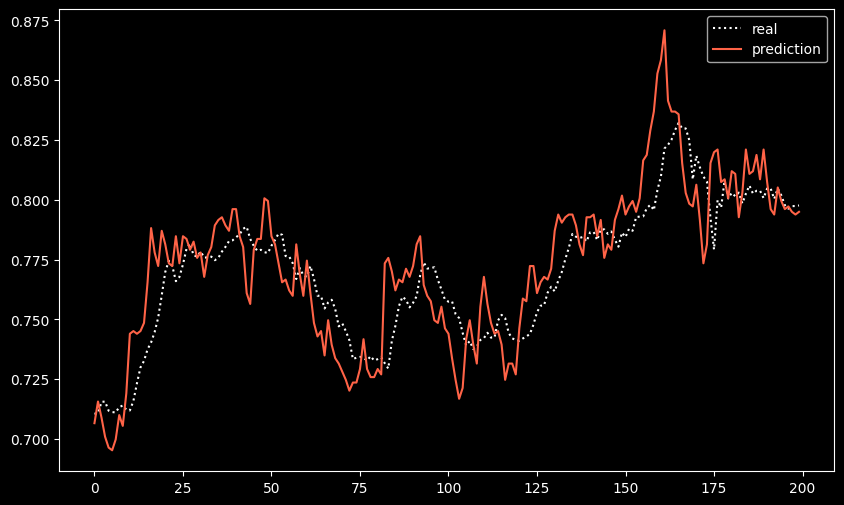

In [82]:
fig, ax = plt.subplots(1, 1)
ax.plot(results, color="white", linestyle="dotted", label="real")
ax.plot(y_valid.detach().cpu().numpy().flatten(), color="tomato", label="prediction")
plt.legend()
plt.show()